In [2]:
import rawpy
from rawpy import RawPy
import exifread
import numpy as np
import torch
from matplotlib import pyplot as plt

In [3]:
def process_ratio(value, simplify=False):
    if isinstance(value, int):
        if simplify:
            return value
        else:
            return f"{value}/1"
    elif isinstance(value, exifread.utils.Ratio):
        return f"{value.num}/{value.den}"

def process_exposure_time(values):
    return process_ratio(values[0])

def process_f_number(values):
    return process_ratio(values[0])

def process_focal_length(values):
    return process_ratio(values[0])

def process_iso_sensitivity(values):
    return process_ratio(values[0], True)

def process_orientation(values):
    # Disable tranform
    return "Horizontal (normal)"

    match values[0]:
        case 1:
            return "Horizontal (normal)"
        case 2:
            return "Mirrored vertical"
        case 3:
            return "Rotated 180"
        case 4:
            return "Mirrored horizontal"
        case 5:
            return "Mirrored horizontal then rotated 90 CW"
        case 6:
            return "Rotated 90 CW"
        case 7:
            return "Mirrored horizontal then rotated 90 CCW"
        case 8:
            return "Rotated 90 CCW"

def extract_extra(tags):
    field_tags = [
        ("camera_name", ["Image Model"], None),
        ("exposure_time", ["EXIF ExposureTime"], process_exposure_time),
        ("f_number", ["EXIF FNumber"], process_f_number),
        ("focal_length", ["EXIF FocalLengthIn35mmFilm", "EXIF FocalLength"], process_focal_length),
        ("iso_sensitivity", ["EXIF ISOSpeedRatings"], process_iso_sensitivity),
        ("orientation", ["Image Orientation"], process_orientation),
    ]
    extras = {}

    for field, tag_candidates, process in field_tags:
        found = False
        for cand in tag_candidates:
            if cand in tags:
                values = tags[cand].values
                value = process(values) if process is not None else values
                extras[field] = value
            found = True
            break
    
        if not found:
            return None
    
    return extras

In [ ]:
def rawpy_to_meta(raw: RawPy, extra: dict) -> dict | None:
    """
    Convert a rawpy.RawPy object to a standardized metadata dictionary.
    """
    if raw.color_desc.decode() != "RGBG":
        return None
    
    # 1. Image size (height, width)
    image_size = (raw.sizes.height // 512 * 512, raw.sizes.width // 512 * 512)
    # 2. Bayer pattern as a 2×2 uint8 array
    bayer_pattern = raw.raw_pattern.astype(np.uint8)
    bayer_pattern[bayer_pattern == 3] = 1
    # 3. Per-channel black level and overall white (saturation) level
    black_level = raw.black_level_per_channel[:3]
    white_level = raw.white_level
    # 4. Camera white-balance gains, normalized so the green channel = 1
    cam_wb = np.array(raw.camera_whitebalance[:3], dtype=float)
    # 5. Camera color‐correction matrix (3×3), here taking the first 3 columns
    full_mat = np.array(raw.color_matrix)
    camera_matrix = full_mat[:, :3].astype(np.float32)

    return {
        'image_size':       image_size,
        'bayer_pattern':    bayer_pattern,
        'black_level':      black_level,
        'white_level':      white_level,
        'white_balance':    cam_wb,
        'camera_matrix':    camera_matrix,
        'camera_name':      extra["camera_name"]
    }

In [5]:
# Disable tranform

# def transform_raw(raw, orientation):
#     match orientation.strip():
#         case "Rotated 180":                             transform = (False, False, 2)
#         case "Rotated 90 CCW":                          transform = (False, False, 1)
#         case "Rotated 90 CW":                           transform = (False, False, 3)
#         case "Mirrored vertical":                       transform = (True,  False, 0)
#         case "Mirrored horizontal":                     transform = (False, True,  0)
#         case "Mirrored horizontal then rotated 90 CCW": transform = (False, True,  1)
#         case "Mirrored horizontal then rotated 90 CW":  transform = (False, True,  3)
#         case _:                                         transform = (False, False, 0)
    
#     if transform[0]:
#         raw = np.flipud(raw)
#     if transform[1]:
#         raw = np.fliplr(raw)
#     raw = np.rot90(raw, transform[2])

#     return raw

def crop(raw, rgb, target_shape):
    shape = raw.shape
    starts = ((shape[0] - target_shape[0]) // 2, (shape[1] - target_shape[1]) // 2)
    ends = (starts[0] + target_shape[0], starts[1] + target_shape[1])
    return (
        raw[starts[0]:ends[0], starts[1]:ends[1]], 
        rgb[starts[0]:ends[0], starts[1]:ends[1], :], 
    )


In [ ]:
import os
from os.path import join
import yaml
import tifffile as tff

folder = "../patchsets/fivek/raw_photos/HQa1to700/photos/"
output = "../patchsets/fivek_processed"
for file in os.listdir(folder):
    # if file != 'a0038-MB_070908_135.dng':
    #     continue
    path = join(folder, file)
    basename = file.split(".")[0]
    out_dir = join(output, basename)

    with open(path, "rb") as f:
        tags = exifread.process_file(f)
    
    extra = extract_extra(tags)
    if extra is None:
        continue

    raw_data =  rawpy.imread(path)
    meta = rawpy_to_meta(raw_data, extra)
    if meta is None:
        continue

    os.makedirs(out_dir, exist_ok=True)

    extra_path = join(out_dir, "extra.yml")
    if not os.path.exists(extra_path):
        with open(extra_path, "w") as f:
            yaml.dump(extra, f, sort_keys=True)
    
    meta_path = join(out_dir, "metadata.pt")
    if not os.path.exists(meta_path):
        torch.save(meta, meta_path)

    raw = raw_data.raw_image_visible
    # Disable tranform
    rgb = raw_data.postprocess(user_flip=0)

    # Disable tranform
    # raw = transform_raw(raw, extra["orientation"])
    # meta["bayer_pattern"] = transform_raw(meta["bayer_pattern"], extra["orientation"])
    # meta["image_size"] = (rgb.shape[0], rgb.shape[1])

    raw, rgb = crop(raw, rgb, meta["image_size"])
    height, width = meta["image_size"]

    for r in range(0, height, 512):
        for c in range(0, width, 512):
            raw_patch = raw[r:r+512, c:c+512]
            rgb_patch = rgb[r:r+512, c:c+512, :]

            raw_filename = f"raw-512-{r:05d}-{c:05d}.tif"
            rgb_filename = f"rgb-512-{r:05d}-{c:05d}.tif"

            raw_path = join(out_dir, raw_filename)
            rgb_path = join(out_dir, rgb_filename)

            tff.imwrite(raw_path, raw_patch)
            tff.imwrite(rgb_path, rgb_patch)

In [59]:
r_mask = np.tile(np.array([[1, 0], [0, 0]]), (height // 2, width // 2))
g_mask = np.tile(np.array([[0, 1], [0, 0]]), (height // 2, width // 2))
b_mask = np.tile(np.array([[0, 0], [0, 1]]), (height // 2, width // 2))

r_raw = (raw * r_mask)[:, :, None] * np.tile(np.array([[[1, 0, 0]]]), (height, width, 1))
g_raw = (raw * g_mask)[:, :, None] * np.tile(np.array([[[0, 1, 0]]]), (height, width, 1))
b_raw = (raw * b_mask)[:, :, None] * np.tile(np.array([[[0, 0, 1]]]), (height, width, 1))

rgb_raw = r_raw + g_raw + b_raw
rgb_raw = (rgb_raw.astype(np.float32) / rgb_raw.max() * 255).astype(np.uint8)
# rgb_raw = (rgb_raw.astype(np.float32) / 500 * 255).astype(np.uint8)

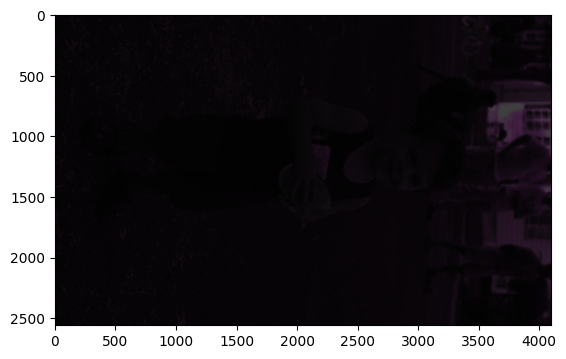

In [60]:
plt.imshow(rgb_raw)

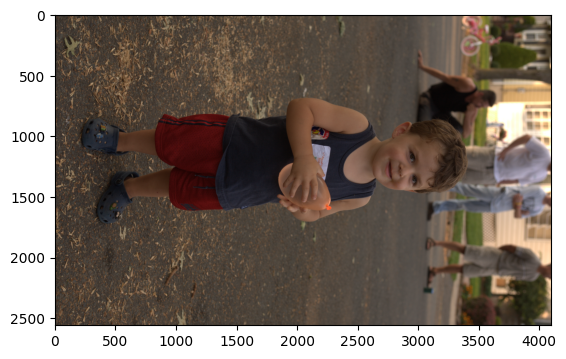

In [ ]:
plt.imshow(rgb)

In [5]:
torch.load("../patchsets/fivek/a0024/metadata.pt")

{'image_size': (2560, 4096),
 'bayer_pattern': array([[0, 1],
        [1, 2]], dtype=uint8),
 'black_level': [0, 0, 0],
 'white_level': 15892,
 'white_balance': array([1.81640506, 1.        , 1.35546899]),
 'camera_matrix': array([[ 1.6694360e+00, -4.8472920e-01, -1.8470675e-01],
        [-9.6069661e-04,  1.2526897e+00, -2.5172901e-01],
        [ 4.7139335e-02, -3.0006602e-01,  1.2529267e+00]], dtype=float32),
 'camera_name': 'NIKON D700'}

In [ ]:
meta_0029 = torch.load("../patchsets/fivek/a0029/metadata.pt")
# meta_0029["bayer_pattern"] = np.array([[0, 1], [1, 2]], dtype=np.uint8) # new
meta_0029["bayer_pattern"] = np.array([[2, 1], [1, 0]], dtype=np.uint8) # old
torch.save(meta_0029, "../patchsets/fivek/a0029/metadata.pt")

In [6]:
torch.load("../patchsets/fivek/a0003/metadata.pt")

{'image_size': (2560, 3584),
 'bayer_pattern': array([[0, 1],
        [1, 2]], dtype=uint8),
 'black_level': [1023, 1023, 1023],
 'white_level': 13600,
 'white_balance': array([2.72363043, 1.        , 1.22167993]),
 'camera_matrix': array([[ 1.7821667 , -0.86549115,  0.08332439],
        [-0.04586181,  1.3752885 , -0.32942668],
        [ 0.05308714, -0.42022175,  1.3671346 ]], dtype=float32),
 'camera_name': 'Canon EOS 40D'}